In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import jaro
import fuzzywuzzy
from thefuzz import fuzz
import Levenshtein
from itertools import combinations
from difflib import get_close_matches

In [2]:
data = pd.read_csv('vehicles.csv')
data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


# 1.  Data understanding

In [19]:
data.columns

Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'odometer',
       'fuel', 'transmission', 'drive', 'type', 'paint_color', 'size',
       'model'],
      dtype='object')

In [4]:
data.shape

(426880, 26)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [9]:
data.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

Print out all of the columns `value_counts()`. Then we analyise by hand what features to use in our model and what not to use.

In [10]:
for column in data.columns:
    print(data[column].value_counts())

7222695916    1
7313139418    1
7313423023    1
7313423324    1
7313424533    1
             ..
7314655506    1
7314655833    1
7314657468    1
7314659947    1
7301591129    1
Name: id, Length: 426880, dtype: int64
https://prescott.craigslist.org/cto/d/prescott-2010-ford-ranger/7222695916.html                     1
https://nh.craigslist.org/cto/d/troy-1998-dodge-ram-59-cummins/7313139418.html                      1
https://nh.craigslist.org/ctd/d/north-hampton-2012-hyundai-sante-fe-se/7313423023.html              1
https://nh.craigslist.org/ctd/d/derry-2008-chrysler-sebring-limited-all/7313423324.html             1
https://nh.craigslist.org/ctd/d/derry-2002-toyota-camry-low-miles/7313424533.html                   1
                                                                                                   ..
https://chicago.craigslist.org/chc/cto/d/pleasant-prairie-2015-f80-m3-700hp-many/7314655506.html    1
https://chicago.craigslist.org/wcl/cto/d/saint-charles-2013-ford-focus-

# 2.  Data preparation

In [3]:
columns = ['price', 'year', 'manufacturer', 'condition',
'cylinders', 'odometer', 'fuel',
'transmission', 'drive', 'type', 'paint_color',
'size','model']

In [4]:
data = data[columns]
data = data.dropna()
data.shape

(79195, 13)

In [5]:
data_old = data.copy()

In [9]:
data['condition'].value_counts()

excellent    39482
good         25320
like new     10603
fair          3006
new            539
salvage        245
Name: condition, dtype: int64

In [38]:
data['condition'] = data['condition'].replace(['like new'], 'excellent')
data['condition'] = data['condition'].replace(['fair'], 'good')
data['condition'].unique()

array(['excellent', 'good', 'new', 'salvage'], dtype=object)

# Removing Outliers

<AxesSubplot:xlabel='year', ylabel='price'>

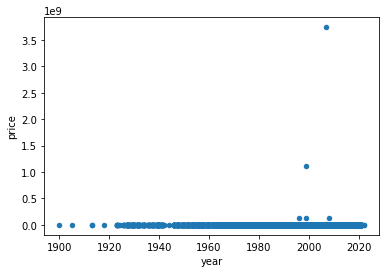

In [20]:
data.plot.scatter(x='year', y='price')

Code by: Parth Chhabra https://www.kaggle.com/getting-started/189761

In [35]:
def remove_outliers(x):
    ## storing names of columns in Column_Names
    Column_Names=x.columns

    ## importing matplotlib and seaborn for visualisation of outliers
    import matplotlib.pyplot as plt
    import seaborn as sns   

    ## iterating through Column_Names using try and except for distinguishing between numerical and categorical columns
    for j in Column_Names:
        try:
            print('Before Removing Outliers')

            ##visualisation of outliers
            a = sns.boxplot(data=x,x=x[j])
            plt.tight_layout() 
            plt.show() 

            xy=x[j]    
            mydata=pd.DataFrame()

            updated=[]
            Q1,Q3=np.percentile(xy,[25,75])
            IQR=Q3-Q1
            minimum=Q1-1.5*IQR
            maximum=Q3+1.5*IQR

            ## using the maximum and minimum values obtained from quartiles and inter-quartile range
            ## any outliers greater than maximum are updated to be equal to maximum
            ## any outliers lesser than minimum are updated to be equal to minimum
            ## here, no outliers have been removed to prevent loss of data

            for i in xy:
                if(i>maximum):
                    i=maximum
                    updated.append(i)
                elif(i<minimum):
                    i=minimum
                    updated.append(i)
                else:
                    updated.append(i)

            x[j]=updated
            print('After Removing Outliers')

            ## visualising after removing outliers
            b= sns.boxplot(data=x,x=x[j])
            plt.tight_layout() 
            plt.show()

        except:
            continue

    return x

In [36]:
columns_clean = ['price', 'year', 'odometer']

In [28]:
data = data_old 

Before Removing Outliers


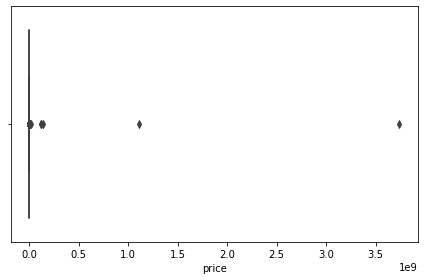

After Removing Outliers


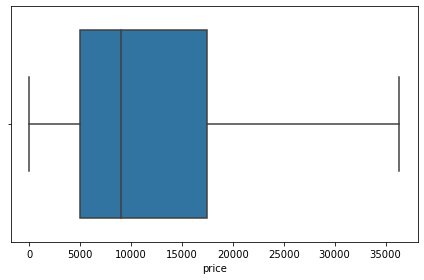

Before Removing Outliers


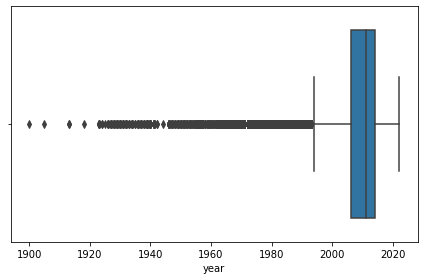

After Removing Outliers


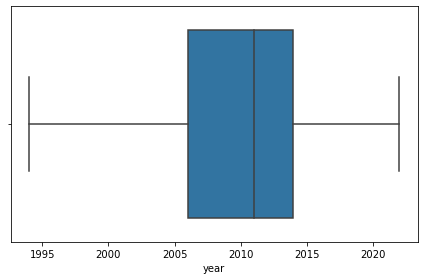

Before Removing Outliers


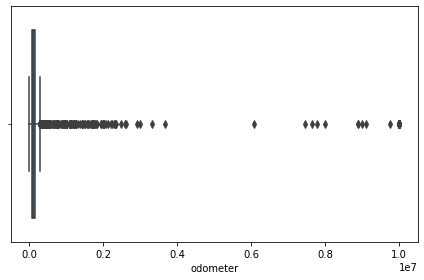

After Removing Outliers


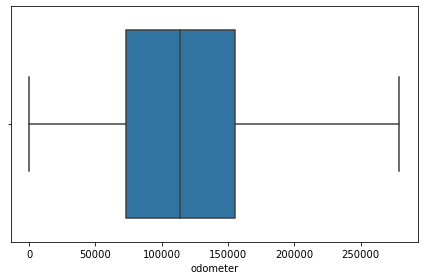

In [37]:
data.loc[:,columns_clean] = remove_outliers(data.loc[:,columns_clean])

In [24]:
data.shape

(79195, 13)

<AxesSubplot:xlabel='year', ylabel='price'>

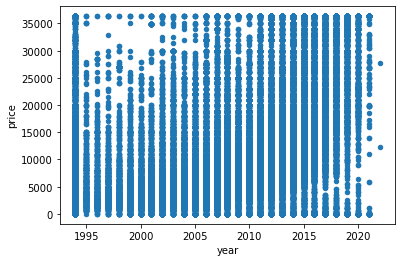

In [25]:
data.plot.scatter(x='year', y='price')

# Model feature grouping

In [11]:
from collections import Counter

In [18]:
def dumbModelCleaner(manufacturer):
    brands = data.groupby(['manufacturer'])
    models = brands.get_group(manufacturer)
    models = models['model'].unique()
    modelList = []
    for i in models:
             for j in i.split():
                    modelList.append(j)
    counts = dict()
    for model in modelList:
        if model in counts:
            counts[model] += 1
        else:
            counts[model] = 1
    counts = Counter(counts)
    for i in models:
        change = False
        for j in i.split():
            if j in counts.most_common(40):
                data['model'] = data['model'].replace([i], j)
                change = True
        if change == False:
            data['model'] = data['model'].replace([i], 'other')
    return data

In [70]:
!pip install jaro-winkler
!pip install fuzzywuzzy
!pip install thefuzz
!pip install python-Levenshtein

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Fuzzy String Matching
https://towardsdatascience.com/fuzzy-string-matching-in-python-68f240d910fe

In [34]:
import jaro
import fuzzywuzzy
from thefuzz import fuzz
import Levenshtein
from itertools import combinations
from difflib import get_close_matches

In [24]:
def model_filter (manufacturer):
    test_group = data.groupby(['manufacturer'])
    car_models = test_group.get_group(manufacturer)
    car_models = car_models['model'].unique()
    car_models.sort()
    car_models = combinations(car_models, 2)
    for i in car_models:
        if fuzz.token_sort_ratio(i[0],i[1]) >= 50:
            data['model'] = data['model'].replace([i[1]], i[0])
            #test_group = data_test.groupby(['manufacturer'])
            #car_models = test_group.get_group(manufacturer)
            #car_models = car_models['model'].unique()
            #car_models.sort()
            #car_models = combinations(car_models, 2)
    return data

In [33]:
manufacturers = data['manufacturer'].unique()
for manufacturer in manufacturers:
    model_filter (manufacturer)

In [95]:
manufacturers = data_test['manufacturer'].unique()
for i in manufacturers:
    model_filter(i)

KeyboardInterrupt: 

In [40]:
from sklearn import preprocessing
import pandas as pd
le = preprocessing.LabelEncoder()   #https://pbpython.com/categorical-encoding.html

In [41]:
data[columns]=data[columns].apply(le.fit_transform)

In [42]:
data['model'].value_counts()

3781    1637
7696    1434
47       882
2041     683
1181     659
        ... 
2421       1
1982       1
5420       1
7250       1
4855       1
Name: model, Length: 9530, dtype: int64

In [25]:
data.head()

,price,year,manufacturer,condition,cylinders,odometer,fuel,transmission,drive,type,paint_color,size,model
31,1901,92,13,0,5,17050,2,0,2,10,0,1,3814
55,2427,83,13,2,6,9872,0,0,0,8,1,1,4178
59,1769,91,16,0,5,11150,2,0,1,5,9,1,6172
65,2635,80,13,2,6,19689,0,1,2,10,10,1,4310
73,1901,96,10,0,6,10208,2,0,2,9,5,2,2202


# 3.  Training model KNN

# 4.  Training model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
y = data['price']
X = data.drop(columns=['price'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, train_size=.2, random_state=1)

In [52]:
# Elastic Net Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
elastic_net_regression = ElasticNet(random_state=0)
elastic_net_regression.fit(X_train, y_train)

# R2 score, MSE and RMSE 
MSE = mean_squared_error(y_test, elastic_net_regression.predict(X_test))
RMSE = np.sqrt(MSE)
print("Elastic net regression RMSE: ", round(RMSE, 2))
print("Elastic net regression score: ", round(elastic_net_regression.score(X_test, y_test),2))

Elastic net regression RMSE:  821.44
Elastic net regression score:  0.39


In [53]:
# Decision tree regression
from sklearn.tree import DecisionTreeRegressor
decision_tree_reg = DecisionTreeRegressor(random_state=0)
decision_tree_reg.fit(X_train, y_train)

# R2 score, MSE and RMSE
r2 = r2_score(y_test, decision_tree_reg.predict(X_test))
MSE = mean_squared_error(y_test, decision_tree_reg.predict(X_test))
RMSE = np.sqrt(MSE)
print("Decision tree R2 score before optimization: ", round(r2, 2))
print("Decision tree RMSE before optimization: ", round(RMSE, 2))
print("Decision tree score before optimization: ", round(decision_tree_reg.score(X_test, y_test),2))

Decision tree R2 score before optimization:  0.44
Decision tree RMSE before optimization:  790.18
Decision tree score before optimization:  0.44


In [51]:
from sklearn.ensemble import RandomForestClassifier# 4.  Training model RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

In [54]:
# Random Forest
RF = RandomForestRegressor(n_estimators=20, random_state=0)
RF.fit(X_train, y_train)

# R2 score, MSE and RMSE before optimization
r2 = r2_score(y_test, RF.predict(X_test))
MSE = mean_squared_error(y_test, RF.predict(X_test))
RMSE = np.sqrt(MSE)
print("Random Forest R2 score before optimization: ", round(r2, 2))
print("Random Forest RMSE before optimization: ", round(RMSE, 2))
print("Random Forest score before optimization: ", round(RF.score(X_test, y_test),2))

# Random search for best hyperparameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
# pprint(random_grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='r2')
# Fit the random search model
rf_random.fit(X_train, y_train)

# best random model
rf_random.best_estimator_

# best combination of parameters of random search
rf_random.best_params_

# New R2 score, MSE and RMSE (best random model RMSE)
random_best= rf_random.best_estimator_.predict(X_test)
final_r2 = r2_score(y_test, random_best)
final_mse = mean_squared_error(y_test, random_best)
final_rmse = np.sqrt(final_mse)
print("Random Forest R2 score after optimization: ", round(final_r2, 2))
print('The best model from the randomized search has a RMSE of: ', round(final_rmse, 2))
print("Random Forest score after optimization: ", round(rf_random.best_estimator_.score(X_test, y_test),2))

Random Forest R2 score before optimization:  0.68
Random Forest RMSE before optimization:  594.84
Random Forest score before optimization:  0.68
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Random Forest R2 score after optimization:  0.7
The best model from the randomized search has a RMSE of:  573.45
Random Forest score after optimization:  0.7
